# Week 2

## Improved plot

- Only consider the mean of "active" simulations
- Also plot deterministic solution
- Only interpolate to next event

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.interpolate import interp1d
from tqdm import tqdm
import scienceplots

plt.style.use(['science','ieee'])

from bp_models.gillespie import run_ensemble_sir

number_of_sims = 500
N = 500
beta = 0.3
mu = 0.2


ts, Is, R_finals, max_t = run_ensemble_sir(N, beta, mu, number_of_sims)

100%|██████████| 500/500 [00:00<00:00, 1335.49it/s]


In [2]:
from scipy.integrate import solve_ivp

def rhs(t, y):
    S = y[0]
    I = y[1]
    R = y[2]
    return [-beta*I*S/N, beta*I*S/N - mu*I, mu*I]

sol = solve_ivp(rhs, t_span=(0, max_t), y0=[N-1, 1, 0], rtol=1e-9)

500it [00:02, 246.26it/s]
/tmp/ipykernel_65758/861170078.py:11: RuntimeWarning: All-NaN slice encountered
  ax.plot(plot_t, np.nanmedian(padded_data, axis=0), 'k', linewidth=2, label="Median")
/home/jakeb/development/Branching-Process-Models/venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


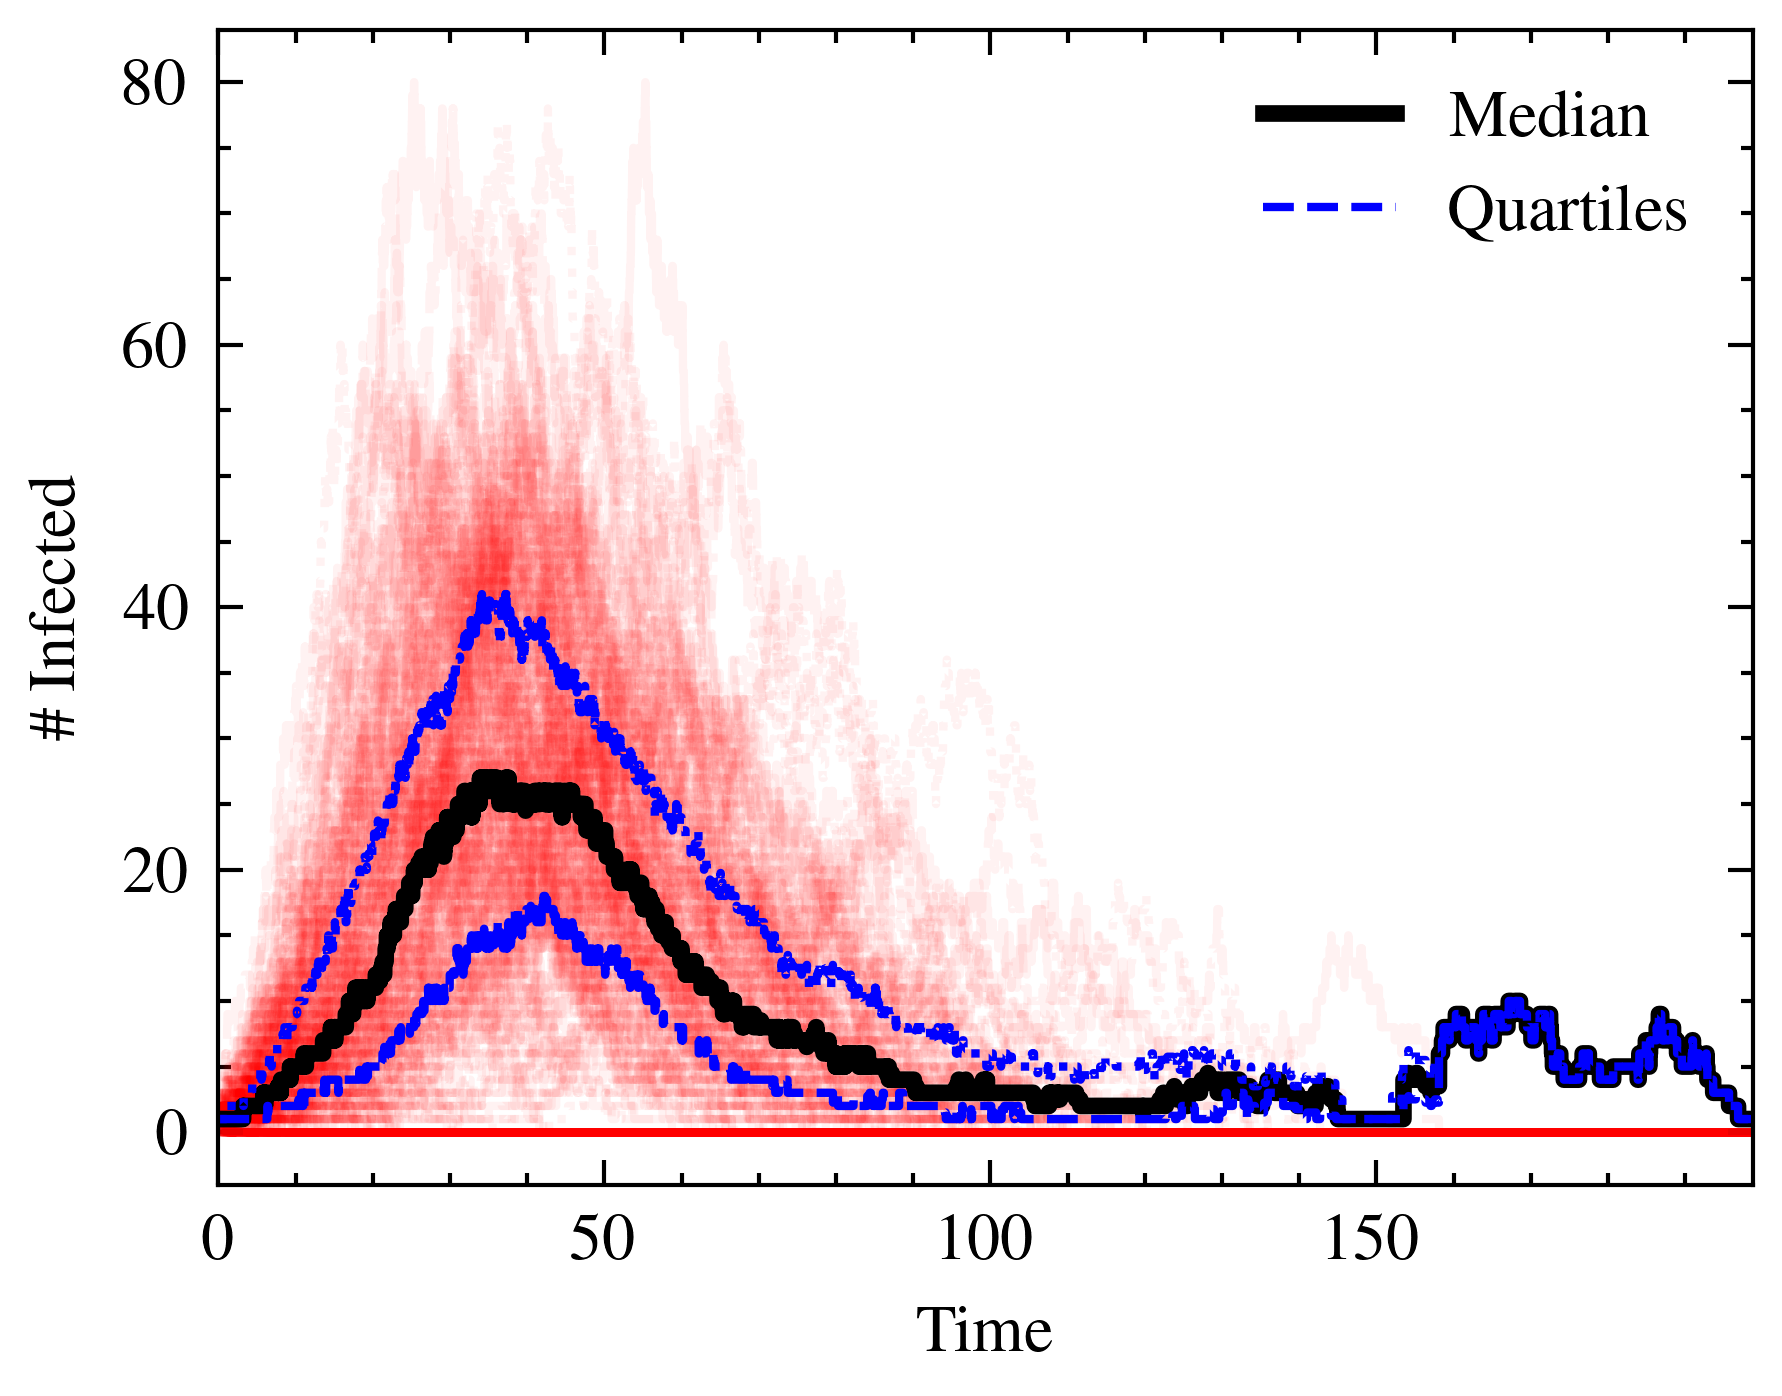

In [5]:
fig, ax = plt.subplots()
plot_t = np.linspace(0, max_t, num=int(max_t)*1000)
padded_data = np.empty((number_of_sims, plot_t.size))
for i, (t, s) in tqdm(enumerate(zip(ts, Is))):
    padded = interp1d(t, s, bounds_error=False, fill_value=0, kind='previous')(plot_t)
    padded_data[i,:] = padded

padded_data = np.asarray(padded_data)
ax.plot(plot_t, padded_data.T, 'r', alpha=0.05)
padded_data[padded_data == 0] = np.nan
ax.plot(plot_t, np.nanmedian(padded_data, axis=0), 'k', linewidth=2, label="Median")
ax.plot(plot_t, np.nanquantile(padded_data, 0.25, axis=0), 'b', linewidth=1, label="Quartiles")
ax.plot(plot_t, np.nanquantile(padded_data, 0.75, axis=0), 'b', linewidth=1, label="_nolegend_")
#ax.plot(sol.t, sol.y[1,:], label="Deterministic")

ax.legend()

ax.set_xlabel("Time")
ax.set_ylabel("\# Infected")
ax.set_xlim([0, max_t])
fig.savefig("figures/gillespie.pdf")